# OVERVIEW

- We compress MNIST data (784 dimensions) into 2 dimensions and then uncompress back to the original size.
- Similare to PCA, except this will be a non-linear dimensionality reduction, due to the non-linear activation functions.

In [35]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from main import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# MNIST Dataset
x_train, x_test, y_train, y_test = eda()
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [37]:
# DIMENSIONALITY REDUCTION
dim = 2

In [46]:
# DENSE ENCODER
de = dense_encoder(x_train.shape[1:], 300, dim)
de.summary()

Model: "Dense-Encocder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)               235500    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 602       
Total params: 236,102
Trainable params: 236,102
Non-trainable params: 0
_________________________________________________________________


In [47]:
# DENSE DECODER
dd = dense_decoder(x_train.shape[1:], 300, dim)
dd.summary()

Model: "Dense-Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 300)               900       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 784)               235984    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 784)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
Total params: 236,884
Trainable params: 236,884
Non-trainable params: 0
_______________________________________________

In [49]:
# DENSE AUTO ENCODER
daei = Input(shape=x_train.shape[1:])
daex = de(daei)
daex = dd(daex)

dae = Model(daei, daex, name="Dense-AutoEncoder")
dae.summary()

Model: "Dense-AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
Dense-Encocder (Model)       (None, 2)                 236102    
_________________________________________________________________
Dense-Decoder (Model)        (None, 28, 28, 1)         236884    
Total params: 472,986
Trainable params: 472,986
Non-trainable params: 0
_________________________________________________________________


In [50]:
# DENSE AUTO ENCODER TRAINING
dae.compile(loss="mse", optimizer=Adam(lr=0.0005))
dae.fit(x_train, x_train, epochs=2, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0600 - val_loss: 0.0553
Epoch 2/2
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0541 - val_loss: 0.0530


In [51]:
# DENSE AUTO ENCODER PREDICTIONS
daep = dae.predict(x_train)
daep.shape

(60000, 28, 28, 1)

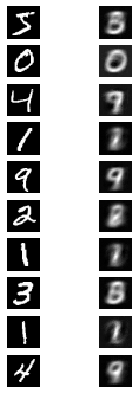

In [54]:
# DENSE AUTO ENCODER : ORIGINAL vs RECONSTRUCTED
n = 10
fig = plt.figure(figsize=(3, 7))
for i in range(n):
    before = x_train[i].reshape(28, 28)
    after = daep[i].reshape(28, 28)
    ax = fig.add_subplot(n, 2, (i * 2) + 1)
    ax.imshow(before, cmap='gray')
    ax.axis('off')
    ax = fig.add_subplot(n, 2, (i * 2) + 2)
    ax.imshow(after, cmap='gray')
    ax.axis('off')

In [ ]:
# ENCODER

ei = Input(shape=(28, 28, 1))
e = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(ei)
e = MaxPooling2D(pool_size=(2,2))(e)
e = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(e)
e = MaxPooling2D(pool_size=(2,2))(e)
e = Flatten()(e)
e = Dense(units=300)(e)
e = LeakyReLU()(e)
e = Dense(units=dim)(e)
eo = LeakyReLU()(e)

encoder = Model(ei, eo)
encoder.summary()

In [ ]:
# DECODER
di = Input(shape=(dim), name="decoder_input")

d = Dense(units=300, name="decoder_dense_1")(di)
d = LeakyReLU(name="decoder_leakyrelu_1")(d)
d = Dense(units=784, name="decoder_dense_2")(d)
d = LeakyReLU(name="decoder_output")(d)

do = Reshape((28, 28, 1))(d)

decoder = Model(di, do, name="decoder_model")
decoder.summary()

In [ ]:
# AUTO ENCODER
ae_input = Input(shape=(28, 28, 1), name="AE_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = Model(ae_input, ae_decoder_output, name="AE")
ae.summary()

In [ ]:
# TRAINING
ae.compile(loss="mse", optimizer=Adam(lr=0.0005))
ae.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

In [ ]:
predictions = ae.predict(x_train)
predictions.shape

In [ ]:
# ORIGINAL vs RECONSTRUCTED
n = 10
fig = plt.figure(figsize=(3, 7))
for i in range(n):
    before = x_train[i].reshape(28, 28)
    after = predictions[i].reshape(28, 28)
    ax = fig.add_subplot(n, 2, (i * 2) + 1)
    ax.imshow(before, cmap='gray')
    ax.axis('off')
    ax = fig.add_subplot(n, 2, (i * 2) + 2)
    ax.imshow(after, cmap='gray')
    ax.axis('off')

In [ ]:
# LATENT SPACE
dim_2 = encoder.predict(x_train)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(*dim_2.T, c=y_train, alpha=0.3, cmap='Spectral')
elements = scatter.legend_elements()
plt.legend(*elements, title='Classes');

In [ ]:
# GENERATING DIGITS BY SAMPLING FROM THE LATENT SPACE
fig = plt.figure(figsize=(15, 7))
for i in range(40):
    x, y = np.random.uniform(-10, 15, 2) # see graph above for potential values
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(decoder.predict([[x, y]]).reshape(28, 28), cmap='gray')
    ax.axis('off')